In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torchvision.datasets import MNIST
from torchvision.transforms.functional import resize as torch_resize
from torchvision.transforms import v2
from sklearn import metrics
from IPython.display import display

In [2]:
def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

In [3]:
letter_trainset = MNIST("../", train=True, download=False)
letter_testset  = MNIST("../", train=False, download=False)
letter_trainset.data[0].size()

torch.Size([28, 28])

In [4]:
n_train_data = 600
n_testn_data = 200


# Train
train_to = letter_trainset.data[letter_trainset.targets == 15][:n_train_data].float()/255
# train_to = torch.from_numpy(dilation(erosion(train_to.numpy())))
train_tx = letter_trainset.data[letter_trainset.targets == 24][:n_train_data].float()/255

train_lo = letter_trainset.targets[letter_trainset.targets == 15][:n_train_data]
train_lx = letter_trainset.targets[letter_trainset.targets == 24][:n_train_data]
train_lo[:] = 1
train_lx[:] = 2

train_t_1 = (torch.randint(low=0, high=15, size=(2*n_train_data,28,28)) == 14).float()
train_t_2 = torch.zeros((n_train_data,28,28))
train_l_ = torch.zeros(train_t_1.shape[0]+train_t_2.shape[0]).long()


x_train = torch.cat((train_to,train_tx,train_t_1,train_t_2))
y_train = torch.cat((train_lo,train_lx,train_l_))

# test
test_to = letter_testset.data[letter_testset.targets == 15][n_train_data:n_train_data+n_testn_data].float()/255
# test_to = torch.from_numpy(dilation(erosion(test_to.numpy())))
test_tx = letter_testset.data[letter_testset.targets == 24][n_train_data:n_train_data+n_testn_data].float()/255

test_lo = letter_testset.targets[letter_testset.targets == 15][n_train_data:n_train_data+n_testn_data]
test_lx = letter_testset.targets[letter_testset.targets == 24][n_train_data:n_train_data+n_testn_data]
test_lo[:] = 1
test_lx[:] = 2

test_t_1 = (torch.randint(low=0, high=15, size=(2*n_testn_data,28,28)) == 14).float()
test_t_2 = torch.zeros((n_testn_data,28,28))
test_l_ = torch.zeros(test_t_1.shape[0]+test_t_2.shape[0]).long()

x_test = torch.cat((test_to,test_tx,test_t_1,test_t_2))
y_test = torch.cat((test_lo,test_lx,test_l_))

print("Train:",x_train.shape)
print("Test :",x_test.shape)

Train: torch.Size([3000, 28, 28])
Test : torch.Size([1000, 28, 28])


In [5]:
train_set = TensorDataset(x_train, y_train)
test_set  = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_set, shuffle=True, batch_size=64, drop_last=True)
test_loader  = DataLoader(test_set, shuffle=True, batch_size=64, drop_last=True)

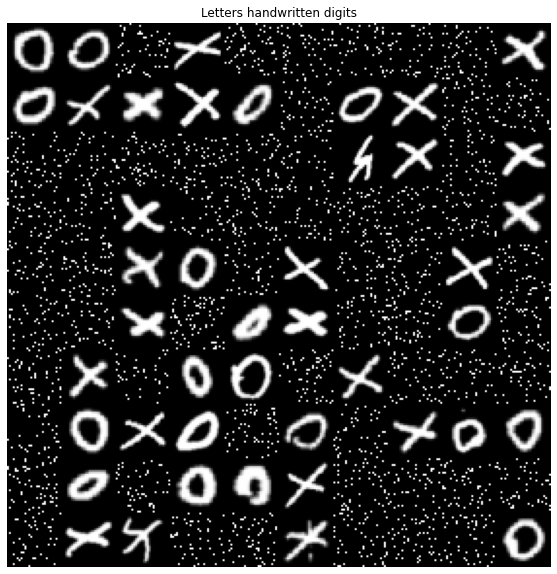

In [6]:
# plot a few MNIST examples
idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx]
        idx = np.random.randint(0, n_train_data*4)

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('Letters handwritten digits')
plt.show()

In [7]:
# Data augmentation
def repaste(imgs : torch.Tensor, N):
    s = np.random.randint(15, size=(2,N))
    o = np.random.randint(15-s)
    imgg = [torch_resize(img[None],ss + 14) for img,ss in zip(imgs,s.T)]
    ximg = torch.zeros((N,28,28))
    # print(o1,o1+s1,o2,o2+s2)
    # print(imgg.shape)
    for i in range(N):
        o0,o1,s0,s1 = o[0,i],o[1,i],s[0,i],s[1,i]
        ximg[i,o0:o0+s0+14,o1:o1+s1+14] = imgg[i]
    return ximg

def img_rotate(imgs : torch.Tensor):
    imgg = []
    rot = v2.RandomRotation(30)
    for i in range(imgs.shape[0]):
        imgg.append(rot(imgs[i:i+1]))
    return torch.cat(imgg)

def add_bar(imgs : torch.Tensor, N):
    pads = np.random.randint(-2,3, size=(2,N))
    for img,a,b in zip(imgs,*pads):
        if a > 0: img[:a,:] = 1
        if a < 0: img[a:,:] = 1
        if b > 0: img[:,:b] = 1
        if b < 0: img[:,b:] = 1
    return imgs

def augment(imgs : torch.Tensor):
    N = imgs.shape[0]
    imgc = imgs.clone()
    return add_bar(img_rotate(repaste(imgc,N)),N)
    

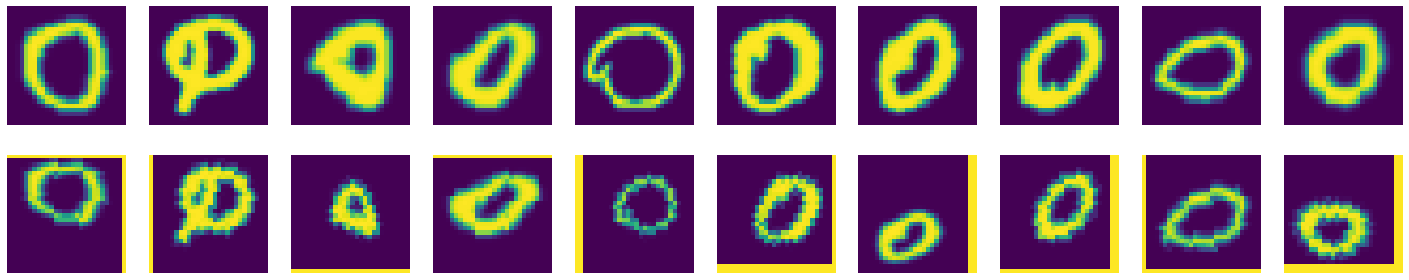

In [9]:
# plt.imshow(x_train[0])
# plt.show()
# for oimg,img in zip(x_train[0:10],):
#     fig,ax = plt.subplots(1,2)
#     ax[0].imshow(oimg)
#     ax[1].imshow(img)
#     plt.show()

fig,ax = plt.subplots(2,10,figsize=(25,5))
for i,oimg,img in zip(range(10),x_train[:10],augment(x_train[0:10])):
    ax[0,i].imshow(oimg)
    ax[1,i].imshow(img)
    ax[0,i].axis("off")
    ax[1,i].axis("off")
plt.axis("off")
plt.show()

In [23]:
#Hyperparameters
num_features = x_train.shape[1]
h1 = 16
h2 = 32
h3 = 64
# define network
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Your code here!
        self.conv1 = nn.Conv2d(1, h1, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(h1, h1, 3, stride=1, padding=1)
        self.BN1   = nn.BatchNorm2d(h1)
        self.conv3 = nn.Conv2d(h1, h2, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(h2, h2, 3, stride=1, padding=1)
        self.BN2   = nn.BatchNorm2d(h2)
        self.conv5 = nn.Conv2d(h2, h3, 3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(h3, h3, 3, stride=1, padding=1)
        self.BN3   = nn.BatchNorm2d(h3)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.5)
        self.flat = nn.Flatten()
        
        self.fc1   = nn.Linear(1568, 1024)
        self.fc2   = nn.Linear(1024, 512)
        self.fc3   = nn.Linear(512, 3)
        
        self.acti = nn.ReLU()
        self.lsoft = nn.LogSoftmax(dim=1)
        

    def forward(self, x):
        # Your code here!
        x = x.view(-1,1,28,28)
        x = self.acti(self.conv1(x))
        x = self.acti(self.conv2(x))
        x = self.BN1(self.pool(x))
        x = self.drop(x)
        x = self.acti(self.conv3(x))
        x = self.acti(self.conv4(x))
        x = self.BN2(self.pool(x))
        x = self.drop(x)
        # x = self.acti(self.conv5(x))
        # x = self.acti(self.conv6(x))
        # x = self.BN3(self.pool(x))
        # x = self.drop(x)
        x = self.flat(x)
        
        x = self.acti(self.fc1(x))
        x = self.acti(self.fc2(x))
        x = self.fc3(x)
        x = self.lsoft(x)
        return x


model = Model()
# use cuda or cpu
if torch.cuda.is_available(): device = torch.device('cuda')  
else:                         device = torch.device('cpu')
# model.load_state_dict(torch.load('model.pth', weights_only=False))
model.to(device)
print(device)
print(model)

optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

cuda
Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.5, inplace=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1568, out_features=1024, bias=True)
  (fc2): Linear(in_features=

In [28]:
batch_size = 64
num_epochs = 200
validation_every_steps = 25

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in (pbar:=tqdm(range(num_epochs))):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = augment(inputs).to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        optimizer.zero_grad()
        output = model(inputs)
        train_loss = loss_fn(output, targets)
        train_loss.backward()
        
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            # print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            # print(f"                 test accuracy: {valid_accuracies[-1]}")
            pbar.set_description(f"Step {step:<5}   training accuracy: {train_accuracies[-1]:.3f}   test accuracy: {valid_accuracies[-1]:.3f}")

print("Finished training.")

  0%|          | 0/200 [00:00<?, ?it/s]

Finished training.


In [ ]:
# valid_accuracies_batches = []
# with torch.no_grad():
#     model.eval()
#     for inputs, targets in test_loader:
#         inputs, targets = inputs.to(device), targets.to(device)
#         output = model(inputs)
#         print(output)
#         loss = loss_fn(output, targets)
#         predictions = output.max(1)[1]
#         # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
#         valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))
#     model.train()
# print(np.sum(valid_accuracies_batches) / len(test_set))

# with torch.no_grad():
#     model.eval()
#     output = model(torch.zeros_like(inputs))
#     print(output)
#     model.train()
# print(np.sum(valid_accuracies_batches) / len(test_set))

In [29]:
import cv2
from time import sleep
state_conversion = {0:"-", 1:"O", 2:"X"}
with torch.no_grad():
    model.eval()
    while True:
        sleep(1)
        img = cv2.imread("box.png")
        if img.any() == None:
            continue
        img_gray = torch.from_numpy(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)).float().to(device)
        out = model(img_gray)
        # print(state_conversion[int(model(img_gray).max(1)[1])])
        # print("".join([f"{i:>12.4f}"for i in model(img_gray).tolist()[0]]))
        # clear_output(wait=False)
        display(" "*(12*out.max(1)[1]+6)+"v",clear=True)
        display("".join([f"{i:>12.4f}"for i in out.tolist()[0]]))


'      v'

'     -0.0001    -11.1106    -10.0306'

KeyboardInterrupt: 

In [30]:
torch.save(model.state_dict(), "model.pth")